#Waymo Open Dataset Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to use the Waymo Open Dataset with two frames of data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



## Install waymo_open_dataset package

library is compiled to pb2 = protobuff format

everything taken from these proto formats

examine Waymo's proto format on images

compare to other models' formats

extract images and labels = bounding box coordinates from Waymo

create new tfrecord from images + labels to train

specify image classification model which easily accepts this new tfrecord
train and apply on test images

In [0]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/r1.0
!pip3 install --upgrade pip

Cloning into 'waymo-od'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 594 (delta 126), reused 138 (delta 74), pack-reused 363
Receiving objects: 100% (594/594), 22.15 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (318/318), done.
* master
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/r1.0
  remotes/origin/r1.0-tf1.15
  remotes/origin/r1.0-tf2.0
Note: checking out 'remotes/origin/r1.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at a66eb0a Merge branch 'master' into r1.0
Requir

In [0]:
!pip3 install waymo-open-dataset
import os
import tensorflow as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

     |████████████████████████████████| 2.7MB 10.2MB/s 


## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [0]:
# start loading frames in normal dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# navigate to the tfrecord
%cd /content/drive/My\ Drive/
%cd data
%cd waymo
# check files in the directory
!ls

/content/drive/My Drive
/content/drive/My Drive/data
/content/drive/My Drive/data/waymo
segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord
segment-10241508783381919015_2889_360_2909_360_with_camera_labels.tfrecord
segment-10500357041547037089_1474_800_1494_800_with_camera_labels.tfrecord
test
train
training_0000.tar
train_labels.csv
validation_0000.tar
waymo-od


In [0]:
# filename = 'segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord'
# filename = 'segment-10241508783381919015_2889_360_2909_360_with_camera_labels.tfrecord'
filename = 'segment-10500357041547037089_1474_800_1494_800_with_camera_labels.tfrecord'

In [0]:
# replaced '/content/waymo-od/tutorial/frames' with filename!!!
frame_num = 0

FILENAME = filename
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
#     frame = open_dataset.Frame()
#     frame.ParseFromString(bytearray(data.numpy()))
#     break
# last training frame_num = 40
  if frame_num == 0:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break
  frame_num = frame_num + 1

# There are 200 frames total
# 199
# 200
# print("number of frames:", str(frame_num+1) )

In [0]:
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

In [0]:
# create a labels csv file
import csv

with open('train_labels.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_NONE) # QUOTE_MINIMAL
    filewriter.writerow(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])

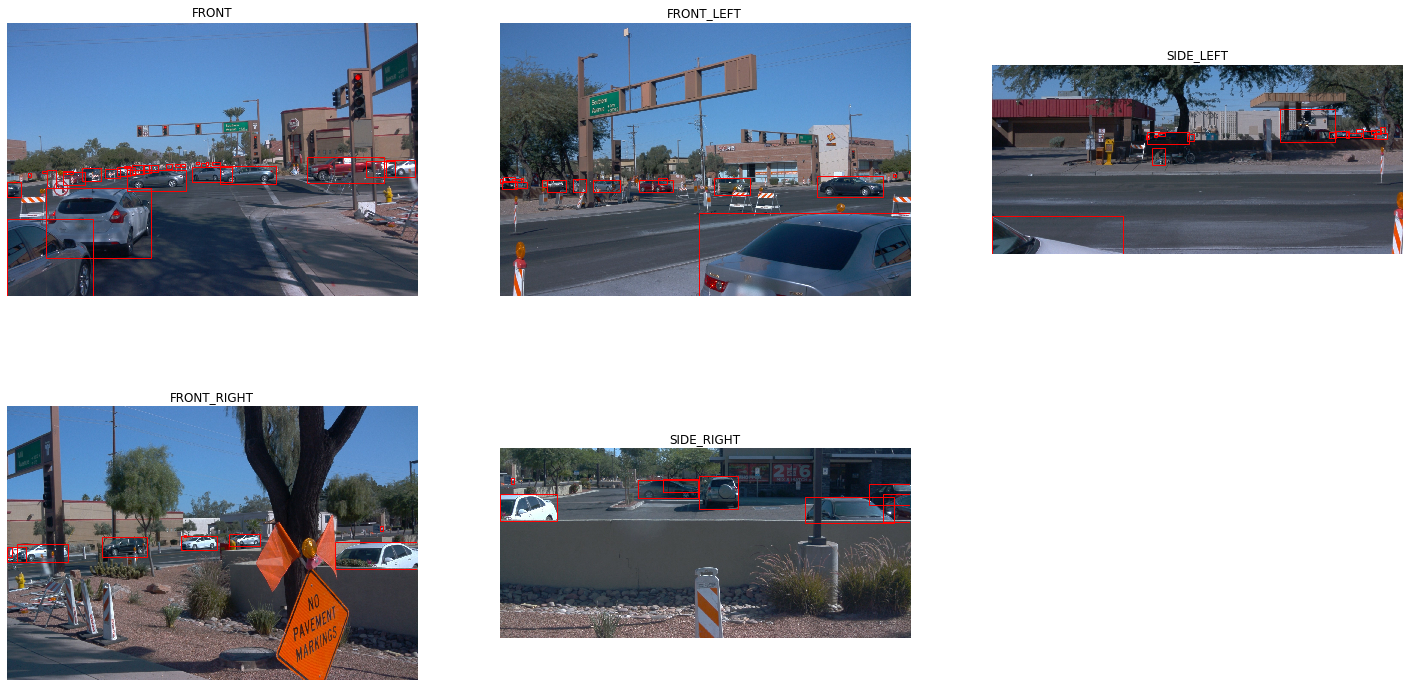

In [0]:
# multiple of 5
count = 0 # 200 end of training = 205 images

# image width and height added to an array, to use in csv file later
widthList = []
heightList = []

import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
def showarray(a, idx, wList, hList, cnt, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()

    # uncomment to show image 
    # can save by right click->save
    # PIL.Image.fromarray(a).save(f, fmt)
    # IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
    filename = "image" + str(idx+cnt) + ".png"
    result = PIL.Image.fromarray(a)
    # save the original unlabeled camera images
    result.save(filename)

    width, height = result.size
    
    wList.append(width)
    hList.append(height)
    
for index, image in enumerate(frame.images):
  showarray(tf.image.decode_jpeg(image.image), index, widthList, heightList, count)

# look at bounding box coordinates to place in csv file
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import csv

def show_camera_image(camera_image, camera_labels, layout, idx, wList, hList, cnt, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  with open('train_labels.csv', 'a') as csvFile:
    writer = csv.writer(csvFile)

    filename = "image" + str(idx+cnt) + ".png"
    img_width = wList[idx]
    img_height = hList[idx]

    # Draw the camera labels.
    for camera_labels in frame.camera_labels:
      # Ignore camera labels that do not correspond to this camera.
      if camera_labels.name != camera_image.name:
        continue

      # Iterate over the individual labels.
      for label in camera_labels.labels:
        # Draw the object bounding box.
        ax.add_patch(patches.Rectangle(
          xy=(label.box.center_x - 0.5 * label.box.length,
              label.box.center_y - 0.5 * label.box.width),
          width=label.box.length,
          height=label.box.width,
          linewidth=1,
          edgecolor='red',
          facecolor='none'))

        # if idx == 2:
          # print("center x:", label.box.center_x)
          # print("center y:", label.box.center_y)
          # print("width:", label.box.width)
          # print("length:", label.box.length)

          # print("x min:", label.box.center_x - 0.5 * label.box.length)
          # print("y min:", label.box.center_y - 0.5 * label.box.width)
          # print("x max:", label.box.center_x + 0.5 * label.box.length)
          # print("y max:", label.box.center_y + 0.5 * label.box.width)

          # print("label:", label.type)

        xmin = int(label.box.center_x - 0.5 * label.box.length)
        ymin = int(label.box.center_y - 0.5 * label.box.width)
        xmax = int(label.box.center_x + 0.5 * label.box.length)
        ymax = int(label.box.center_y + 0.5 * label.box.width)

        row_class = ''
        if label.type == 1:
          row_class = "car"
        elif label.type == 2:
          row_class = "person"
        elif label.type == 3:
          row_class = "traffic light"
        elif label.type == 4:
          row_class = "bicycle"
        else:
          row_class = "unknown"

        # if idx == 2:
        row = [filename, img_width, img_height, row_class, xmin, ymin, xmax, ymax]
        writer.writerow(row)
        
    csvFile.close()
      
  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1], index, widthList, heightList, count)

###Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [0]:
print(frame.context)

name: "10500357041547037089_1474_800_1494_800"
camera_calibrations {
  name: FRONT
  intrinsic: 2076.077969921609
  intrinsic: 2076.077969921609
  intrinsic: 953.7331466947504
  intrinsic: 663.0316255790619
  intrinsic: 0.04421872649818653
  intrinsic: -0.33103920080697136
  intrinsic: 0.002210459294288001
  intrinsic: 6.169860842486829e-06
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999917302498417
    transform: -0.003994405895710026
    transform: 0.0007642993314375604
    transform: 1.544279559549856
    transform: 0.003990847097749586
    transform: 0.999981444912251
    transform: 0.0046024961324261544
    transform: -0.023893054691341304
    transform: -0.0007826693874827448
    transform: -0.004599407869164356
    transform: 0.9999891163787149
    transform: 2.1160759505137725
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: RIGHT_TO_LEFT
}
camera_calibrations {
  name: FRONT_LEFT
  in

In [0]:
# from https://github.com/waymo-research/waymo-open-dataset/issues/24
# projects a point to image without taking rolling shutter and distortion into account
def project_point(point, camera_calibration):
  # vehicle frame to camera sensor frame.
  extrinsic = tf.reshape(camera_calibration.extrinsic.transform, [4, 4])
  vehicle_to_sensor = tf.matrix_inverse(extrinsic)
  point1 = point
  point1.append(1)
  point_camera_frame = tf.einsum('ij,j->i', vehicle_to_sensor, tf.constant(point1, dtype=tf.float32))
  u_d = - point_camera_frame[1] / point_camera_frame[0]
  v_d = - point_camera_frame[2] / point_camera_frame[0]
 
  # add distortion model here if you'd like.
  f_u = camera_calibration.intrinsic[0];
  f_v = camera_calibration.intrinsic[1];
  c_u = camera_calibration.intrinsic[2];
  c_v = camera_calibration.intrinsic[3];
  u_d = u_d * f_u + c_u;
  v_d = v_d * f_v + c_v;

  return [u_d.numpy(), v_d.numpy()]

## Visualize Camera Images and Camera Labels

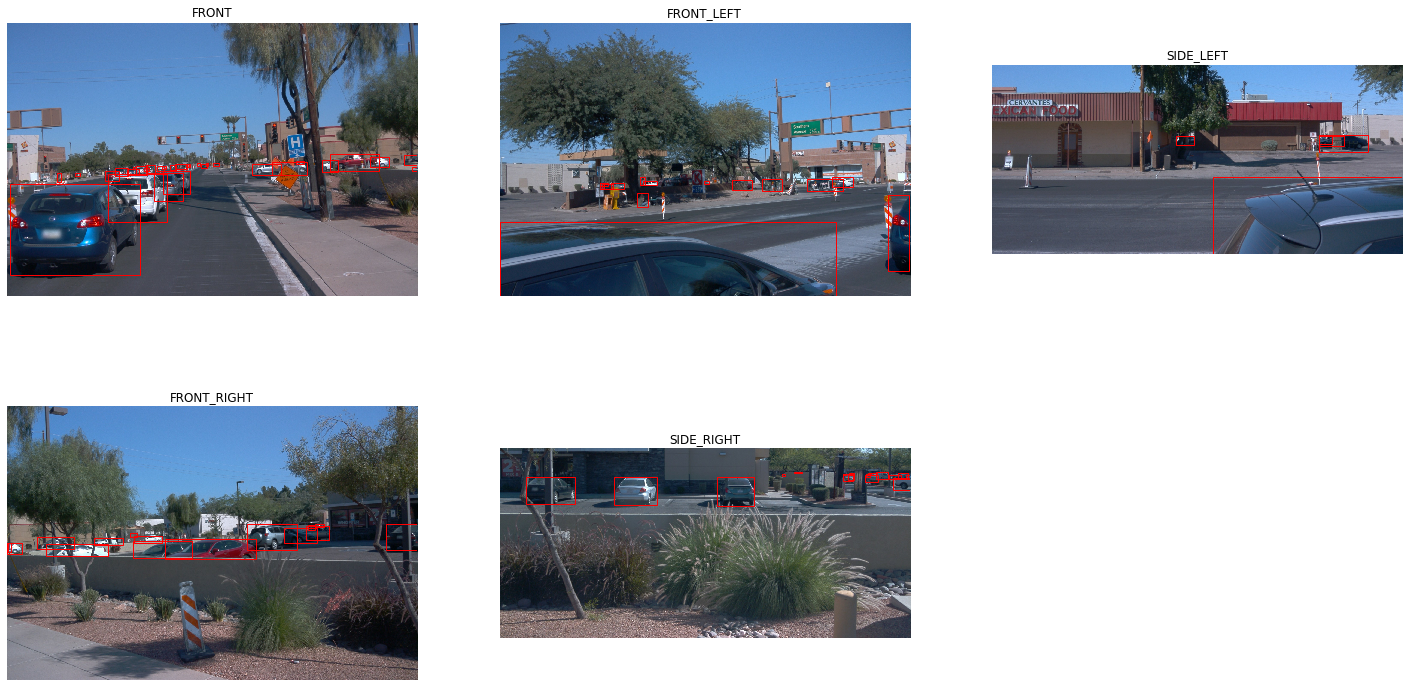

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))
 
  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

##Visualize Range Images

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


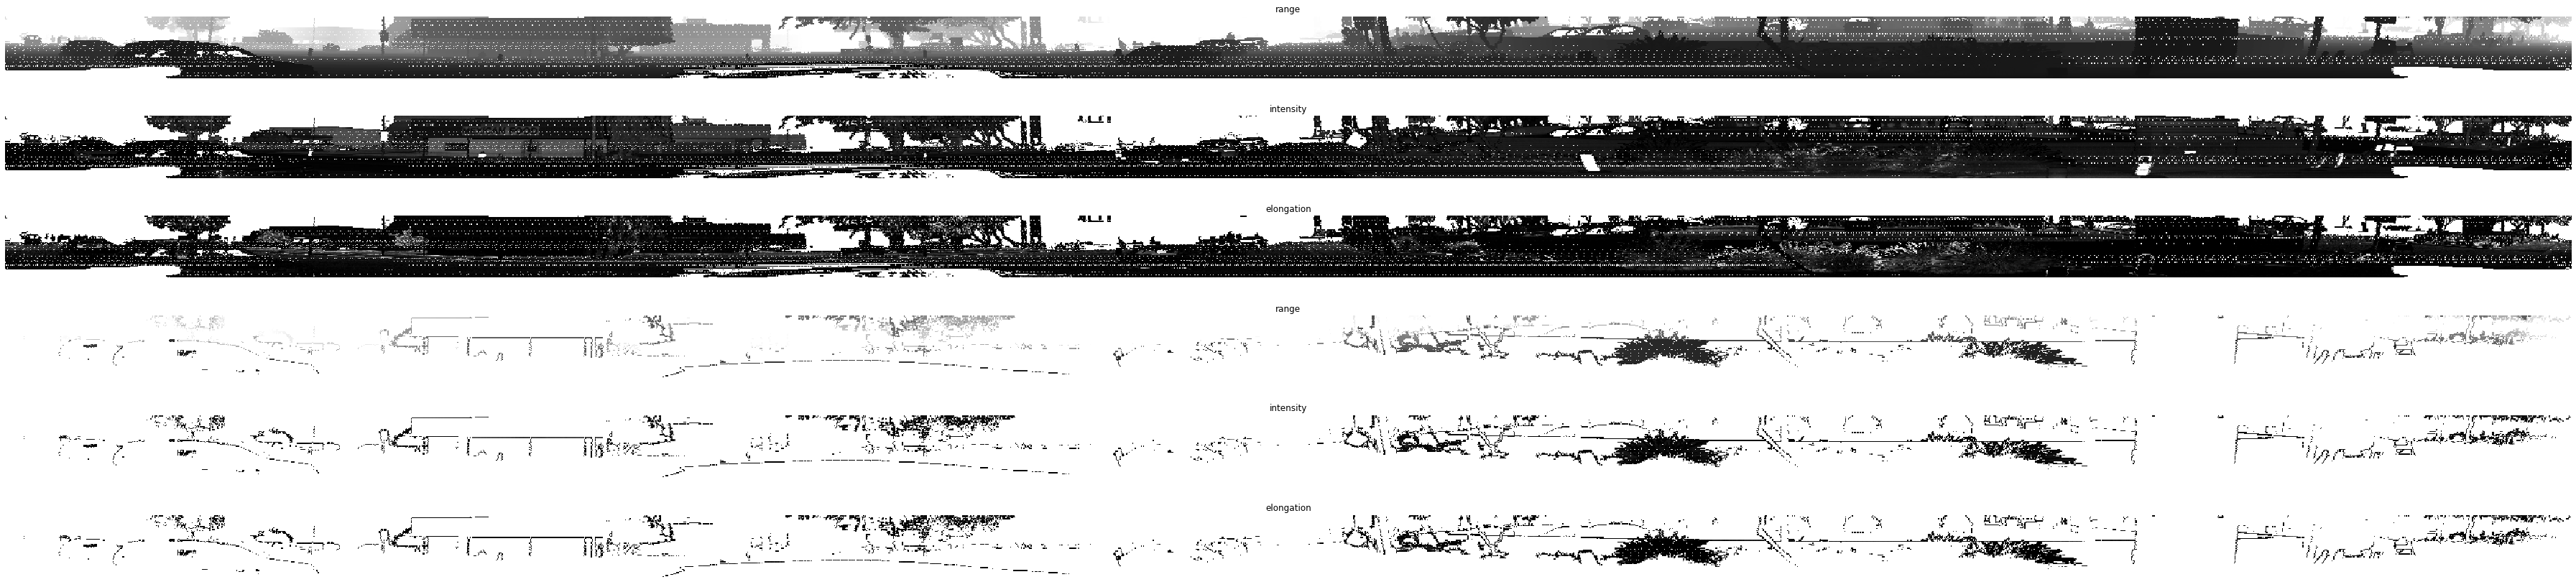

In [0]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

##Point Cloud Conversion and Visualization

In [0]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

###Examine number of points in each lidar sensor.

First return.

In [0]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(150337, 3)
(150337, 6)
[[-53.983456   19.628687    4.3781595]
 [-54.001884   19.783026    4.380591 ]]
(133064, 3)
(133064, 6)
(3948, 3)
(3948, 6)
(4055, 3)
(4055, 6)
(4622, 3)
(4622, 6)
(4648, 3)
(4648, 6)


Second return.

In [0]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(13194, 3)
(13194, 6)
[[-57.838333   22.591698    4.550192 ]
 [-56.328842   22.326637    4.4934616]]
(12976, 3)
(12976, 6)
(46, 3)
(46, 6)
(5, 3)
(5, 6)
(138, 3)
(138, 6)
(29, 3)
(29, 6)


###Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

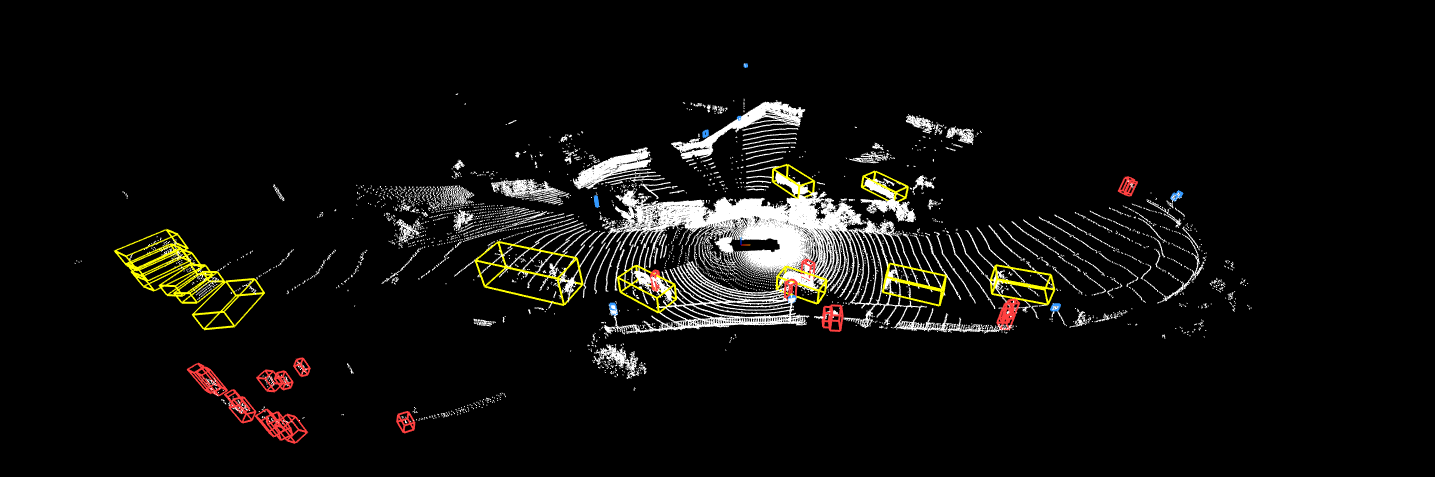

In [0]:
from IPython.display import Image, display
display(Image('/content/waymo-od/tutorial/3d_point_cloud.png'))

##Visualize Camera Projection

In [0]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [0]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

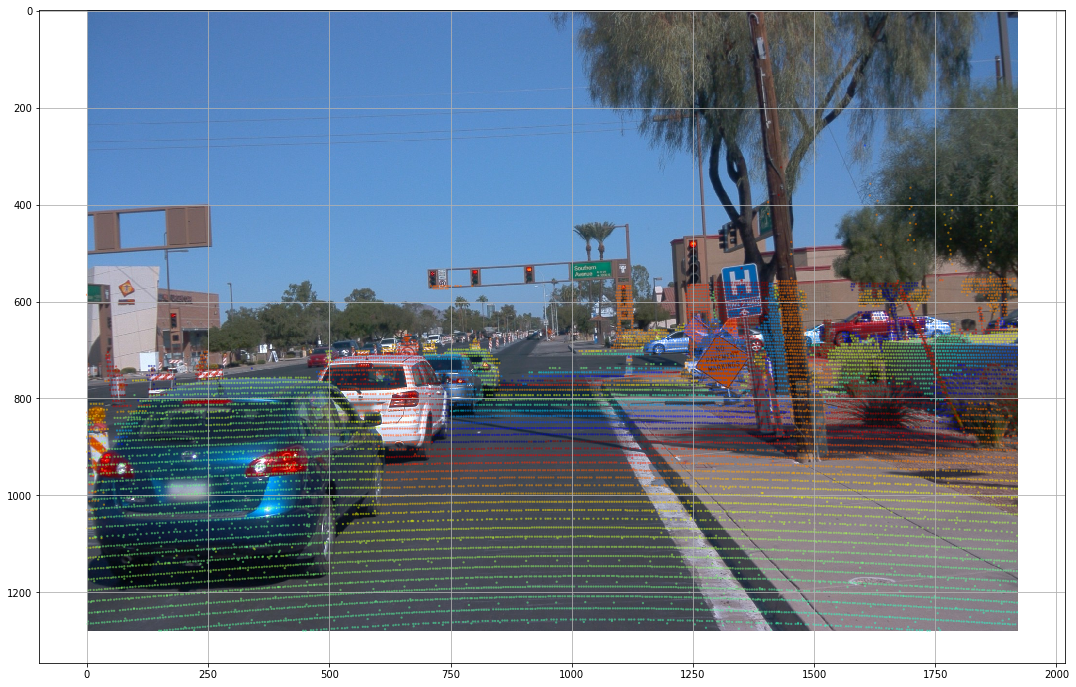

In [0]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

## Install from source code

The remaining part of this colab covers details of installing the repo form source code which provides a richer API.

### Install dependencies

In [0]:
!sudo apt install build-essential
!sudo apt-get install --assume-yes pkg-config zip g++ zlib1g-dev unzip python3 python3-pip
!wget https://github.com/bazelbuild/bazel/releases/download/0.28.0/bazel-0.28.0-installer-linux-x86_64.sh
!sudo bash ./bazel-0.28.0-installer-linux-x86_64.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
unzip is already the newest version (6.0-21ubuntu1).
zip is already the newest version (3.0-11build1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
python3 is already the newest version (3.6.7-1~18.04).
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secretstorage python3-setuptools python3-si

###Build and test (this can take 10 mins)

Configure .bazelrc. This works with/without Tensorflow. This colab machine has Tensorflow installed.

In [0]:
!cd waymo-od && ./configure.sh && cat .bazelrc && bazel clean

/bin/bash: ./configure.sh: /bin/bash: bad interpreter: Permission denied


KeyboardInterrupt: ignored

In [0]:
!cd waymo-od && bazel build ... --show_progress_rate_limit=10.0

### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [0]:
!cd waymo-od && bazel-bin/waymo_open_dataset/metrics/tools/compute_detection_metrics_main waymo_open_dataset/metrics/tools/fake_predictions.bin  waymo_open_dataset/metrics/tools/fake_ground_truths.bin

#### TensorFlow custom op

A TensorFlow op is defined at metrics/ops/metrics_ops.cc. We provide a python wrapper of the op at metrics/ops/py_metrics_ops.py, and a tf.metrics-like implementation of the op at metrics/python/detection_metrics.py. This library requires TensorFlow to be installed.

Install TensorFlow and NumPy.

In [0]:
!pip3 install numpy tensorflow

Reconfigure .bazelrc such that you can compile the TensorFlow ops

In [0]:
!cd waymo-od && ./configure.sh && cat .bazelrc

Run the op and tf.metrics wrapper unit tests which can be referenced as example usage of the libraries.

In [0]:
!cd waymo-od && bazel test waymo_open_dataset/metrics/ops/... && bazel test waymo_open_dataset/metrics/python/...

Run all tests in the repo.

In [0]:
!cd waymo-od && bazel test ...

### Build local PIP package

In [0]:
!cd waymo-od && export PYTHON_VERSION=3 && ./pip_pkg_scripts/build.sh
!ls ./package